In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
sys.path.append("..")
from modules.utils import paper_style
from sklearn.metrics import r2_score

paper_style()

from helper_fn import *

sys.path.append("..")

# from modules.utils import paper_style

# loading GT stuff

# current_dir = os.path.dirname(os.path.abspath(__file__))
current_dir = ""
relative_path = "../data"
path = os.path.join(current_dir, relative_path)
data_path = os.path.join(path, "test/")
data_drug_path = os.path.join(path, "test_drug/")
gt_path = os.path.join(path, "GT/")
gt_drug_path = os.path.join(path, "GT_drug/labels/")

drug = False

if drug:
    data_path_ = data_drug_path
    gt_path_ = gt_drug_path
else:
    data_path_ = data_path
    gt_path_ = gt_path

gt_tracks = []
taus = []
for i, fn in enumerate(os.listdir(gt_path_)):
    track = np.load(os.path.join(gt_path_, fn)).squeeze().T
    tau = np.linspace(0, 1, track.shape[0])
    gt_tracks.append(track)
    taus.append(tau)

crossing_points_gt, idx_gt = find_crossing_points(taus, gt_tracks)

track_lengths = [track.shape[0] for track in gt_tracks]

modalities = ["bf", "h2b"]

In [2]:
data = {}
errors_g = {}
errors_r = {}
for mod in modalities:
    data[mod] = {}
    errors_g[mod] = {}
    errors_r[mod] = {}
    for head in heads:
        # loading the dataset
        tracks = get_data(data_path_, mod, head)
        data[mod][head] = tracks

        # getting the mean error profile
        n_tracks = len(tracks)
        fucci_labels = ["green", "red"]

        errors_g_unrolled, errors_r_unrolled, taus_unrolled = track_errors_flattened(
            gt_tracks, tracks
        )

        errors_g_averaged, bins = bin_avarage_errors(errors_g_unrolled, taus_unrolled)
        errors_r_averaged, bins = bin_avarage_errors(errors_r_unrolled, taus_unrolled)

        errors_g[mod][head] = errors_g_averaged
        errors_r[mod][head] = errors_r_averaged

In [3]:
len(gt_tracks)

taus_unrolled = []
gt_tracks_unrolled_g = []
gt_tracks_unrolled_r = []
n_tracks = len(gt_tracks)

for i in range(n_tracks):
    track = gt_tracks[i]
    taus_unrolled.append(taus[i])
    gt_tracks_unrolled_g.append(track[:, 0])
    gt_tracks_unrolled_r.append(track[:, 1])

gt_tracks_unrolled_g = np.concatenate(gt_tracks_unrolled_g)
gt_tracks_unrolled_r = np.concatenate(gt_tracks_unrolled_r)
taus_unrolled_n = np.concatenate(taus_unrolled)



def bin_std_errors(track, taus, n_bins=30):

    bins = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(taus, bins) - 1  # Bin indices (0-indexed)

    # Compute bin averages
    std_profile = np.array(
        [
            track[bin_indices == i].std() if np.any(bin_indices == i) else 0
            for i in range(n_bins)
        ]
    )
    return std_profile, bins

std_g, bins = bin_std_errors(gt_tracks_unrolled_g, taus_unrolled_n, n_bins=30)
std_r, _ = bin_std_errors(gt_tracks_unrolled_r, taus_unrolled_n, n_bins=30)


In [4]:
# name of all heads
heads = ["mlp", "cnn", "lstm", "xtransformer-causal", "mamba", "xtransformer"]


# colors assigned to each head, can be improved
available_colors = ['#95cee1',"#f19e21","brown", "royalblue", "#0a4d8b",    "#f60b20",]

head_colors = {
    head: available_colors[i % len(available_colors)] for i, head in enumerate(heads)
}

# subset of heads to plot
good_heads = ["mlp", "cnn", "mamba", "xtransformer"]

# Create a dictionary to map head names to new labels
head_name_map = {
    'mlp': 'Single Frame',
    'cnn': 'Causal CNN',
    'mamba': 'Mamba',
    'xtransformer': 'Transformer'
}



## avarage error profile

In [5]:
def paper_style():
    plt.rcParams.update(
        {
            "figure.figsize": (7, 5),  # Default figure size (width, height) in inches
            "axes.titlesize": 18,  # Title font size
            "axes.labelsize": 16,  # Axis label font size
            "xtick.labelsize": 11,  # X-tick label font size
            "ytick.labelsize": 11,  # Y-tick label font size
            "legend.fontsize": 14,  # Legend font size
            "legend.title_fontsize": 16,  # Legend title font size
            # 'font.family': 'serif',              # Font family (you can change this to 'sans-serif' or 'monospace')
            # 'font.serif': ['Times New Roman'],   # Font choice, adjust to your needs
            "axes.linewidth": 1.5,  # Width of the axis lines
            "lines.linewidth": 2.5,  # Line width for plots
            "axes.spines.top": True,  # Disable top spine
            "axes.spines.right": True,  # Disable right spine
            "legend.frameon": False,  # Disable legend box
            "savefig.dpi": 300,  # Set DPI for saving figures, important for publication-quality figures
            "savefig.format": "pdf",  # Default file format when saving figures
        }
    )
paper_style()

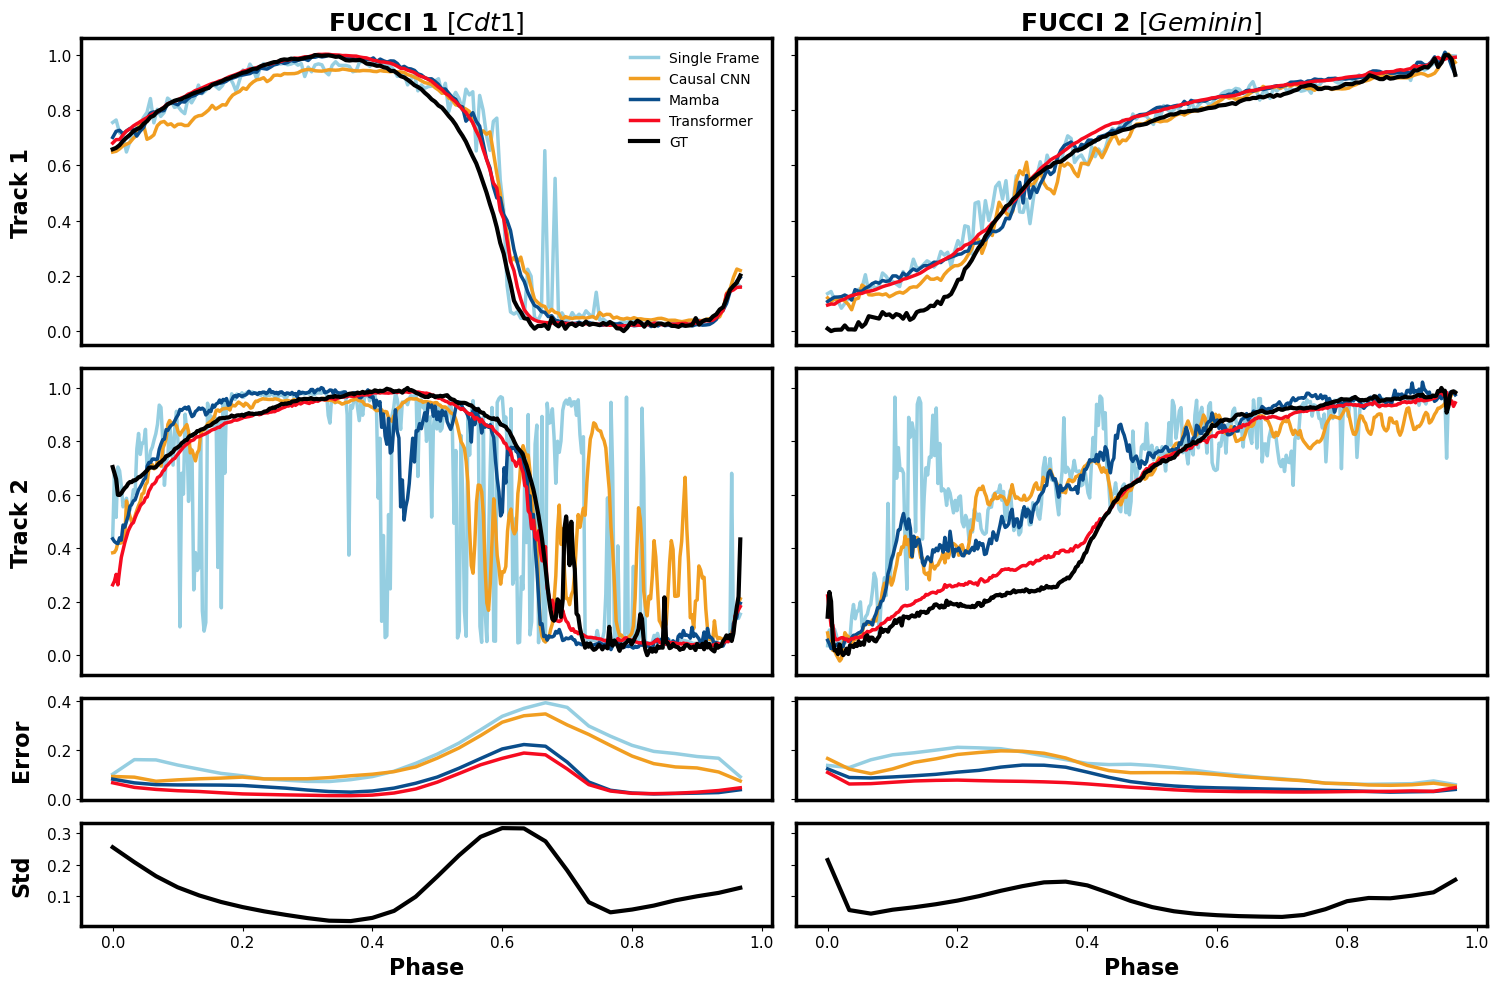

In [6]:
# Adjust the figure layout for 4 rows with equal height for the first two rows and smaller for the last two
fig, axs = plt.subplots(
    4, 2, figsize=(15, 10), sharey='row', gridspec_kw={'height_ratios': [3, 3, 1, 1]}
)

# Function to apply consistent styling
def style_subplot(ax):
    ax.grid(False)
    ax.set_xlabel(ax.get_xlabel(), fontweight="bold")
    ax.set_ylabel(ax.get_ylabel(), fontweight="bold")
    ax.set_title(ax.get_title(), fontweight="bold")
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(2.5)



# Function to plot data for each axis
def plot_data(ax, data, idx, head_colors, good_heads, gt_tracks, col_idx, is_first_subplot=False):
    for head in good_heads:
        # Map head name to new label using the dictionary
        new_label = head_name_map.get(head, head)
        ax.plot(data[mod][head][idx][:, col_idx], label=f"{new_label}", color=head_colors[head])
    
    # Plot GT track
    ax.plot(gt_tracks[idx][:, col_idx], label="GT", color="k", linewidth=3)
    
    # Add legend only in the first subplot
    if is_first_subplot:
        ax.legend(loc="upper right", fontsize=10)
    
    style_subplot(ax)
    ax.set_xticks([])

# Plot for each axis
idx1, idx2 = 6, 2

# Track 1
plot_data(axs[0, 0], data, idx1, head_colors, good_heads, gt_tracks, 1, is_first_subplot=True)  # RED
axs[0, 0].set_title("FUCCI 1 $[Cdt1]$", fontweight="bold")
axs[0, 0].set_ylabel("Track 1", fontweight="bold")
axs[0, 1].set_title("FUCCI 2 $[Geminin]$", fontweight="bold")
plot_data(axs[0, 1], data, idx1, head_colors, good_heads, gt_tracks, 0)  # GREEN

# Track 2
plot_data(axs[1, 0], data, idx2, head_colors, good_heads, gt_tracks, 1)  # RED
plot_data(axs[1, 1], data, idx2, head_colors, good_heads, gt_tracks, 0)  # GREEN
axs[1, 0].set_ylabel("Track 2", fontweight="bold")

# Error plots
for ax, errors, ylabel in zip([axs[2, 0], axs[2, 1]], [errors_r, errors_g], ["Error", ""]):
    for head in good_heads:
        ax.plot(bins[:-1], errors[mod][head], label=f"{head}", color=head_colors[head])
    style_subplot(ax)
    ax.set_ylabel(ylabel, fontweight="bold")
    ax.set_xticks([])

# Standard deviation plots
for ax, std, ylabel in zip([axs[3, 0], axs[3, 1]], [std_r, std_g], ["Std", ""]):
    ax.plot(bins[:-1], std, color="k" , linewidth=3)
    style_subplot(ax)
    ax.set_ylabel(ylabel, fontweight="bold")
    ax.set_xlabel("Phase", fontweight="bold")

# Align y labels at the same position
for ax in axs[:, 0]:  # For all axes in the first column
    ax.yaxis.set_label_coords(-0.07, 0.5)  # Adjust x and y coordinates for y-label

# Ensure tight layout and consistent scaling
plt.tight_layout()
plt.show()


# drugs

Here I do the same thing, just switch the drug flag on

In [7]:
drug = True

if drug:
    data_path_ = data_drug_path
    gt_path_ = gt_drug_path
else:
    data_path_ = data_path
    gt_path_ = gt_path

data_d = {}


modalities = ["bf", "h2b"]
for mod in modalities:
    data_d[mod] = {}
    for head in heads:
        tracks = get_data(data_path_, mod, head)
        data_d[mod][head] = tracks

gt_tracks_d = []
taus_d = []
for i, fn in enumerate(os.listdir(gt_path_)):
    track = np.load(os.path.join(gt_path_, fn)).squeeze().T
    tau = np.linspace(0, 1, track.shape[0])
    gt_tracks_d.append(track)
    taus_d.append(tau)
    


In [8]:
data = {}

for mod in modalities:
    data[mod] = {}
    for head in heads:
        # loading the dataset
        tracks = get_data(data_path_, mod, head)
        data[mod][head] = tracks

        # getting the mean error profile
        n_tracks = len(tracks)
        fucci_labels = ["green", "red"]

        

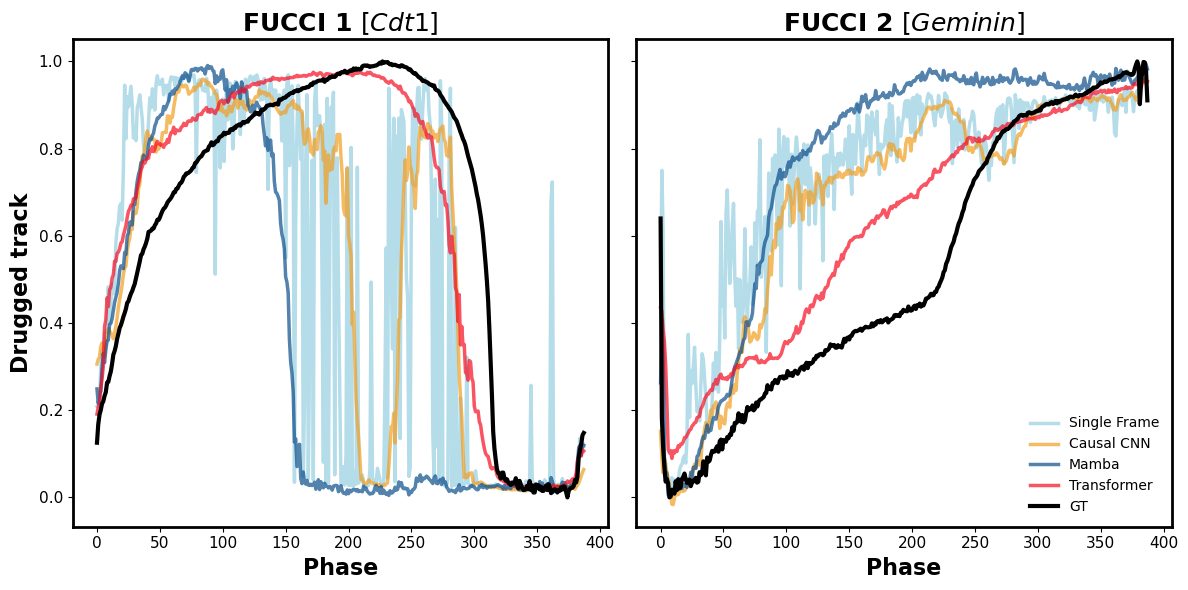

In [9]:

# Choose modality here
mod = "bf"
# Choose track here
idx = 23
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Left subplot for errors_g_averaged
ax1.set_title("FUCCI 2 $[Geminin]$", fontweight="bold")
ax1.set_xlabel("Phase", fontweight="bold")
ax2.set_ylabel("Drugged track", fontweight="bold")

# Plot data on the left subplot
for head in good_heads:
    # Map head names
    new_label = head_name_map.get(head, head)
    ax1.plot(data[mod][head][idx][:, 0], label=f"{new_label}", color=head_colors[head], alpha=0.7)

# Ground truth (GT) track
ax1.plot(gt_tracks_d[idx][:, 0], label="GT", color="black", linewidth=3)
ax1.legend(loc="lower right", fontsize=10)
ax1.grid(False)  # Turn off the grid

# Right subplot for errors_r_averaged
ax2.set_title("FUCCI 1 $[Cdt1]$", fontweight="bold")
ax2.set_xlabel("Phase", fontweight="bold")

# Plot data on the right subplot
for head in good_heads:
    # Map head names
    new_label = head_name_map.get(head, head)
    ax2.plot(data[mod][head][idx][:, 1], label=f"{new_label}", color=head_colors[head], alpha=0.7)

# Ground truth (GT) track
ax2.plot(gt_tracks_d[idx][:, 1], label="GT", color="black", linewidth=3)
ax2.grid(False)  # Turn off the grid

# Add thick borders to all four sides of each subplot
for ax in [ax1, ax2]:
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(2.)  # Set thickness for all four sides

plt.tight_layout()
# put legend in right bottom corner of 2nd subplot



# Save the figure or show it
# plt.savefig(f"../plots/av_error/profile_{mod}.pdf")
plt.show()
